# API example: end-to-end adversarial detection

This notebook shows how to use the **high-level public API** (re-exported from `src`) to:

- load a dataset from the registry
- build/train a model
- generate adversarial examples (FGSM/PGD)
- compute graph/topology scores
- fit the detector
- evaluate AUROC/AUPRC/FPR@95%TPR

Notes:
- This repo’s detector is standardized to the **topology-score detector** (`TopologyScoreDetector`).
- External datasets (MNIST/CIFAR via torchvision) are supported **without auto-download by default**.


In [16]:
import numpy as np
import sys
from pathlib import Path

# Make `import src.*` work when running from nested directory
REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "src").exists() and (REPO_ROOT.parent / "src").exists():
    REPO_ROOT = REPO_ROOT.parent.resolve()

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
    
from src import (
    ExperimentConfig,
    load_config,
    list_datasets,
    list_models,
    run_pipeline,
)

# Load a base YAML config from ./config/ (convenience wrapper)
# cfg = load_config("fgsm_eps0p02_nopca")

# Create experiment configuration
SEED = 42
config = ExperimentConfig(
    seed=SEED,
    device='cpu'  # Change to 'cuda' if GPU is available
)

# Modify config as needed
# More samples -> more *successful* attacks -> less "stair-steppy" ROC curves.
config.data.n_samples = 5000
config.data.noise = 0.1
config.model.epochs = 30
config.model.learning_rate = 0.001

# Attacks (used only to generate evaluation data)
config.attack.attack_type = 'fgsm'
config.attack.epsilon = 0.1

# Representation space for neighborhoods (recommended: feature space)
config.graph.space = 'feature'  # 'input' or 'feature'
config.graph.k = 10

# Enable topology features (persistent homology) on local neighborhoods
config.graph.use_topology = True
config.graph.topo_k = 50
config.graph.topo_maxdim = 1   # compute H0/H1
config.graph.topo_min_persistence = 1e-6

# Topology scoring detector: PH feature vector -> Mahalanobis score -> clean percentile threshold
config.detector.detector_type = 'topology_score'
# Optional: explicitly select which PH feature keys to use (otherwise defaults are chosen)
# config.detector.topo_feature_keys = [
#     'topo_h0_total_persistence',
#     'topo_h1_total_persistence',
#     'topo_h1_entropy',
# ]
config.detector.topo_percentile = 95.0
config.detector.topo_cov_shrinkage = 1e-3

print("datasets:", list_datasets())
print("models:", list_models())

datasets: ['breast_cancer_tabular', 'cifar10', 'cifar100', 'fashion_mnist', 'mnist', 'synthetic_shapes_2class', 'synthetic_shapes_3class', 'two_moons']
models: ['minicnn', 'two_moons_mlp']


Epoch [10/30] Train Loss: 0.0061, Train Acc: 99.90%, Val Loss: 0.0071, Val Acc: 99.80%
Epoch [20/30] Train Loss: 0.0027, Train Acc: 99.93%, Val Loss: 0.0060, Val Acc: 99.80%
Epoch [30/30] Train Loss: 0.0020, Train Acc: 99.93%, Val Loss: 0.0049, Val Acc: 99.80%
AUROC: 0.6440030000000001
AUPRC: 0.6754857789263753
FPR@95TPR: 0.918


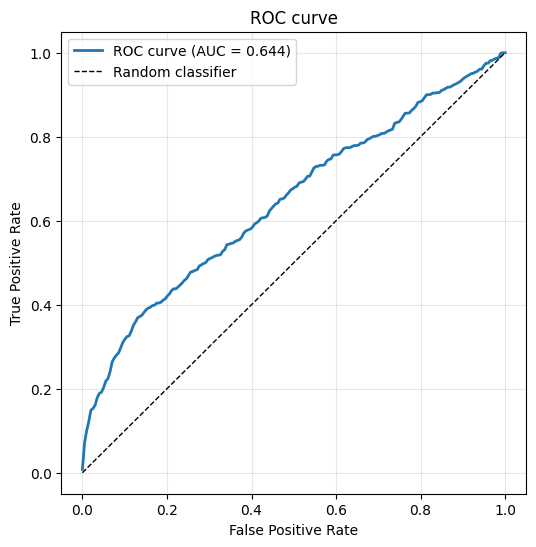

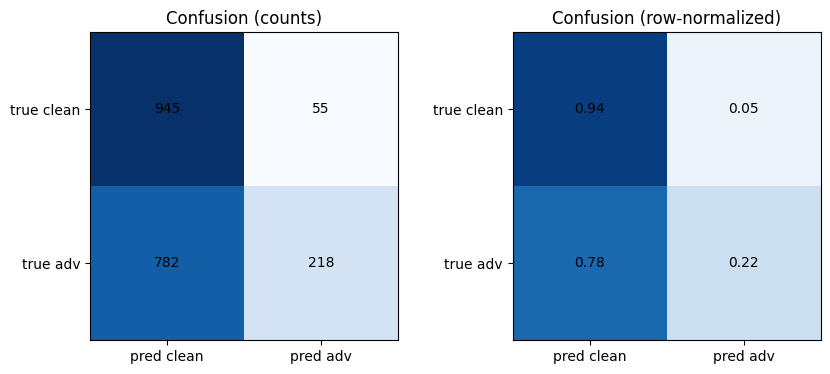

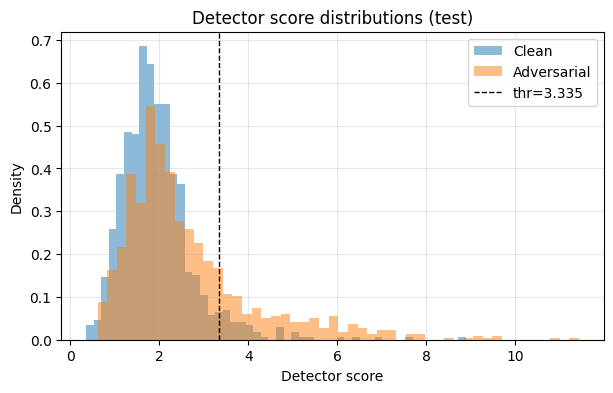

In [17]:
# End-to-end run on a built-in dataset (two moons)
# Note: to match `01_graph_manifold_two_moons.ipynb`, evaluate on *successful* attacks only.
result = run_pipeline(
    dataset_name="two_moons",
    model_name="two_moons_mlp",
    cfg=config,
    eval_only_successful_attacks=True, # I think we should eval only on successful attacks since we don't care about other attacks (to increase robustness we only care about successful attacks)
    seed=config.seed,
)

print("AUROC:", result.eval.metrics["roc_auc"])
print("AUPRC:", result.eval.metrics["pr_auc"])
print("FPR@95TPR:", result.eval.metrics["fpr_at_tpr95"])